This notebook shows how to use Julia's DiffEqFlux library to implement neural ODEs. This is just a simple example, but see [here](https://diffeqflux.sciml.ai/stable/) for official tutorials and examples.

Use 'Shift + Enter' to run a cell.

We first need to load in the Julia libraries for building and training neural ODEs. This step might take a couple minutes.

In [1]:
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim
using Plots

The first thing we need to do is load in some data. We will choose a spiral of the form $\langle x(t),y(t) \rangle= \langle (1+t)\cos(t), (1+t)\sin(t) \rangle$. This is inspired by an example given in the [2018 Neural ODEs paper](https://arxiv.org/abs/1806.07366).

In [2]:
ϵ = 0.3                 # scale of noise
t_final = 4.0           # final time point
n_data = 60             # number of data points

t_data = range(0,stop=t_final,length=n_data)
data = zeros(2,n_data)
data[1,:] = (t_data .+ 1).*cos.(t_data) + ϵ*rand(n_data)
data[2,:] = (t_data .+ 1).*sin.(t_data) + ϵ*rand(n_data)

60-element Array{Float64,1}:
  0.16829453178086962
  0.1592094362574656
  0.1929950297556668
  0.44472025269025023
  0.37609941740229214
  0.46813630486837704
  0.7664238261102432
  0.6764105167415202
  0.9030043545760555
  1.2174070926304168
  1.1095492337636417
  1.2947237422976083
  1.3509658324905556
  ⋮
 -0.4315805242986991
 -0.6959220062620268
 -0.9052900949544442
 -1.090300720155791
 -1.4687510743296732
 -1.7305885169264787
 -2.2805388762096346
 -2.4086406815476096
 -2.772237171257008
 -2.946962410021295
 -3.4902478803100947
 -3.619854828904819

To give us an idea of what we're looking at, let's plot it.

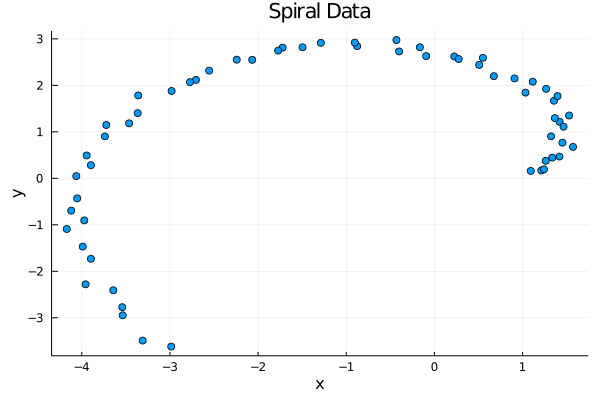

In [3]:
scatter(data[1,:],data[2,:],xlabel="x",ylabel="y",title="Spiral Data",label="")

Now that we have our data, we need to set up a machine learning model. We could use a regression technique, or a classical neural network. Instead, we'll use a "Neural ODE", where the goal is to model the *derivatives* of our data. We could do this from scratch, but instead we will make use of the Julia library [DiffEqFlux](https://diffeqflux.sciml.ai/dev/).

In [4]:
u0 = Float32[data[1,1]; data[2,1]]            # initial condition for ODE
tspan = (0.0f0, Float32(t_final))             # span of data (as 32-bit float)
n_dims = length(u0)                           # dimensions of data
width = 20                                    # width of neural network

model = FastChain(FastDense(n_dims, width, tanh),
                  FastDense(width, n_dims))
prob_neuralode = NeuralODE(model, tspan, Tsit5(), 
                           saveat = t_data,
                           relerr = 1e-6, abserr = 1e-6)

(::NeuralODE{FastChain{Tuple{FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float32,Float32},Tuple{Tsit5},Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:saveat, :relerr, :abserr),Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Float64,Float64}}}}) (generic function with 4 methods)

The variable 'model' sets up our neural network, and 'prob_neuralode' sets up the problem to be solved using the [DifferentialEquations](https://diffeq.sciml.ai/v2.0/) library. This library has many advanced solver features such as adaptive time stepping, callback control, and many, many choices for discretization. Above we chose the Tsit5 solver which is [recommended](https://diffeq.sciml.ai/stable/solvers/ode_solve/) for non-stiff systems.

We now have to define two things:
* How to evaluate this neural network
* How the loss function is defined

In [5]:
function predict_neuralode(p)
  Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, data .- pred)
    return loss, pred
end

loss_neuralode (generic function with 1 method)

Because we are learning the dynamics of our data, and not the data values itself, whenever we evaluate our neural network we really need to solve an ODE system. This evaluation is computed in 'predict_neuralode', which takes in 'p' for the network parameters. In a real problem we might also want to make 'predict_neuralode' a function of the initial condition u0, but for our purposes this works fine as it is.

Our loss function is a standard sum of squares, defined in 'loss_neuralode', which also depends on the network parameters.

One last thing we will define is a 'callback function' to be inserted into the ODE solver. Typically these are used for event handling, but we will use it to plot the model prediction as it is trained.

In [16]:
iter = 0
callback = function (p, l, pred; doplot = true)
  global iter
  iter += 1

  if doplot && (mod(iter,3) == 0)
    IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
    plt = scatter(data[1,1:size(pred,2)], data[2,1:size(pred,2)], label = "data",title = string("iter: ",iter))
    scatter!(plt, pred[1,1:size(pred,2)], pred[2,1:size(pred,2)], label = "prediction",xlim=(-5,2.5),ylim=(-4,4))
    plot(plt) |> IJulia.display
  end

  return false
end

#13 (generic function with 1 method)

Everything is set up to run, all that is left to do is actually train the model. Again, this is where the DiffEqFlux library does the heavy lifting, as we only need to call a single function: 'sciml_train'. 

This function takes in: 
* loss function (loss_neuralode)
* model parameters (prob_neuralode.p)
* optimization method ( ADAM(0.05) )
* callback function (cb=callback)
* maximum iterations it should run (maxiters=300)

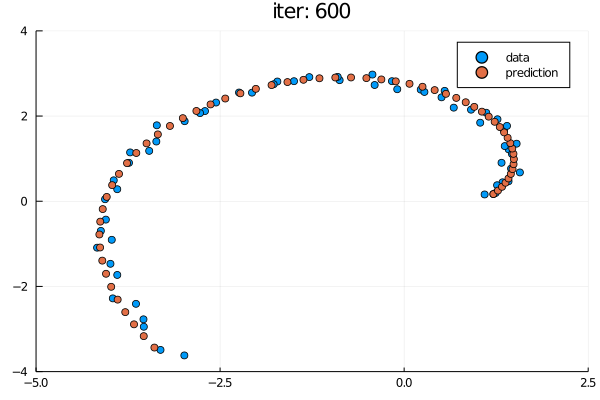

loss: 1.73: 100%|███████████████████████████████████████| Time: 0:00:27


 * Status: success

 * Candidate solution
    Final objective value:     1.732146e+00

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    600
    f(x) calls:    600
    ∇f(x) calls:   600


In [17]:
iter = 0       # reset iter (in case you run this multiple times)
result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, prob_neuralode.p,
                                          ADAM(0.05), cb = callback,
                                          maxiters = 600)

and now our model is trained! The summary above give some idea of how the training process went. 

(Note: The NaN values in "Convergence measures" are actual values when I run this code outside of a jupyter notebook. Not sure what's going on here)

So, how do you access the parameter values that define your trained model? With result_neuralode.minimizer. So, for example, we could generate our prediction with 'predict_neuralode(result_neuralode.minimizer)'.

Occasionally, we will want to combine different optimization techniques on the same problem, for example using a cheap, coarse optimization method in the beginning and then switch to something that is more accurate once we get 'close' to the local minimum. The code below does exactly this, using the [L-BFGS optimization algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS). Note that 'result_neuralode.minimizer' is passed in as the parameter value so that we start from the previous parameter values and don't start training the model from scratch again.

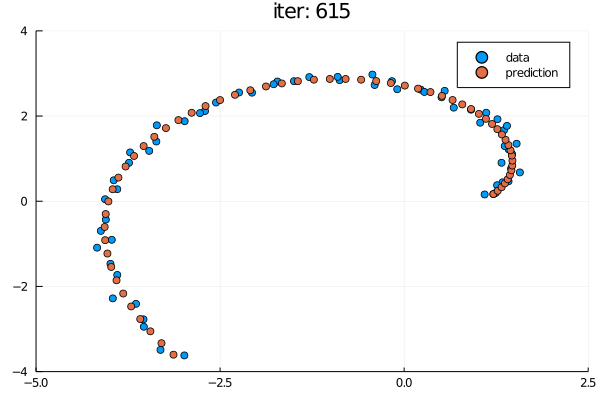

 * Status: success

 * Candidate solution
    Final objective value:     9.073377e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.30e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    14
    f(x) calls:    213
    ∇f(x) calls:   213


In [18]:
result_neuralode2 = DiffEqFlux.sciml_train(loss_neuralode,
                                           result_neuralode.minimizer,
                                           LBFGS(),
                                           cb = callback,
                                           allow_f_increases = true)

That's all there is to it! The Julia library DiffEqFlux allows us to handle much more complex cases than the one demonstrated here.

For more information, see one of the following links:
* [DiffEqFlux announcement](https://julialang.org/blog/2019/01/fluxdiffeq/)
* [DiffEqFlux github page](https://github.com/SciML/DiffEqFlux.jl)
* [SciML homepage](https://sciml.ai/)